# Analysis of physical activity (steps) logged by a smartwatch

## Table of contents
1. [Read the dataset and print basic statistics](#read)
2. Plots
  1. [Daily steps](#daily)
  1. [Average hourly steps during the day](#hourly)
  1. [Average 15-mins steps during the day](#15min)
  1. [Average steps per day of the week](#dow)

In [19]:
import json
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib._color_data as mcd
pd.plotting.register_matplotlib_converters()

In [20]:
DATA_FILES_DIR = 'user-site-export/'
OUTPUT_CHARTS_DIR = './'
DATE_FORMAT = "%d/%m/%Y"
TIMESTAMP_FORMAT = DATE_FORMAT + ' %H:%M'

In [21]:
def get_data(name, file_filter):
    print(f'Processing {name} data...')
    file_list = glob.glob(DATA_FILES_DIR + file_filter)
    dataList = []
    print(f'\tFound {len(file_list)} files to process')
    for file_name in file_list:
        with open(file_name,'r') as file_in:
            data = json.loads(file_in.read())
            dataList.extend(data)
    return pd.DataFrame(dataList)

In [22]:
# Check if dirs exist and create them if they don't
if not os.path.exists(DATA_FILES_DIR):
    print(f'ERROR: cannot find dir {DATA_FILES_DIR}')
if not os.path.exists(OUTPUT_CHARTS_DIR):
    os.makedirs(OUTPUT_CHARTS_DIR)

## Read the dataset and print basic statistics <a name="read"></a>

In [23]:
df = get_data("STEPS", "steps-*.json")
df.index = pd.to_datetime(df['dateTime'])
df['value'] = pd.to_numeric(df['value'], downcast='unsigned')
start_day = df.index[0]
end_day = df.index[-1]
print(f'\tData from {start_day.strftime(DATE_FORMAT)} to '
                f'{end_day.strftime(DATE_FORMAT)}, '
                f'{(end_day-start_day).days + 1:,} days, '
                f'{df.shape[0]} records')
print(f"\tMax spike {df['value'].max()} steps "
      f"at {df['value'].idxmax().strftime(TIMESTAMP_FORMAT)}")

Processing STEPS data...
	Found 15 files to process
	Data from 20/01/2019 to 06/04/2020, 442 days, 271259 records
	Max spike 126 steps at 16/03/2019 09:56


## Daily steps <a name="daily"></a>

	Max daily 24,297 steps on 09/10/2019
	Min daily 114 steps on 07/09/2019
	Mean daily 5437 steps
	Total 2,408,746 steps


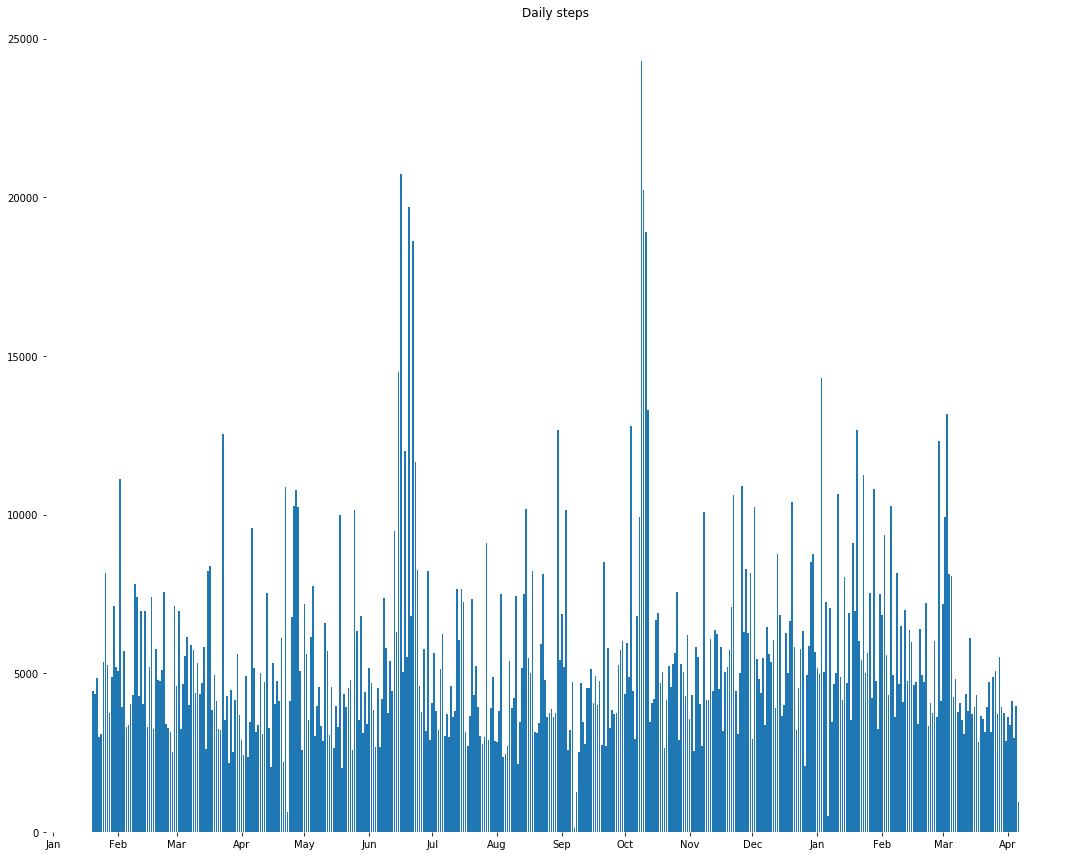

In [30]:
daily_steps = df['value'].resample('D').sum()
daily_steps = pd.to_numeric(daily_steps, downcast='unsigned')
print(f"\tMax daily {daily_steps.max():,} steps "
      f"on {daily_steps.idxmax().strftime(DATE_FORMAT)}")
print(f"\tMin daily {daily_steps.min()} steps "
      f"on {daily_steps.idxmin().strftime(DATE_FORMAT)}")
print(f"\tMean daily {daily_steps.mean():.0f} steps")
print(f"\tTotal {daily_steps.sum():,} steps")
fig, ax = plt.subplots(figsize=(15, 12))
ax.bar(daily_steps.index, daily_steps)
plt.title(f'Daily steps')
plt.box(False)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.tight_layout()
plt.savefig(OUTPUT_CHARTS_DIR + 'daily_steps.png', dpi=300)

## Average hourly steps during the day <a name="hourly"></a>

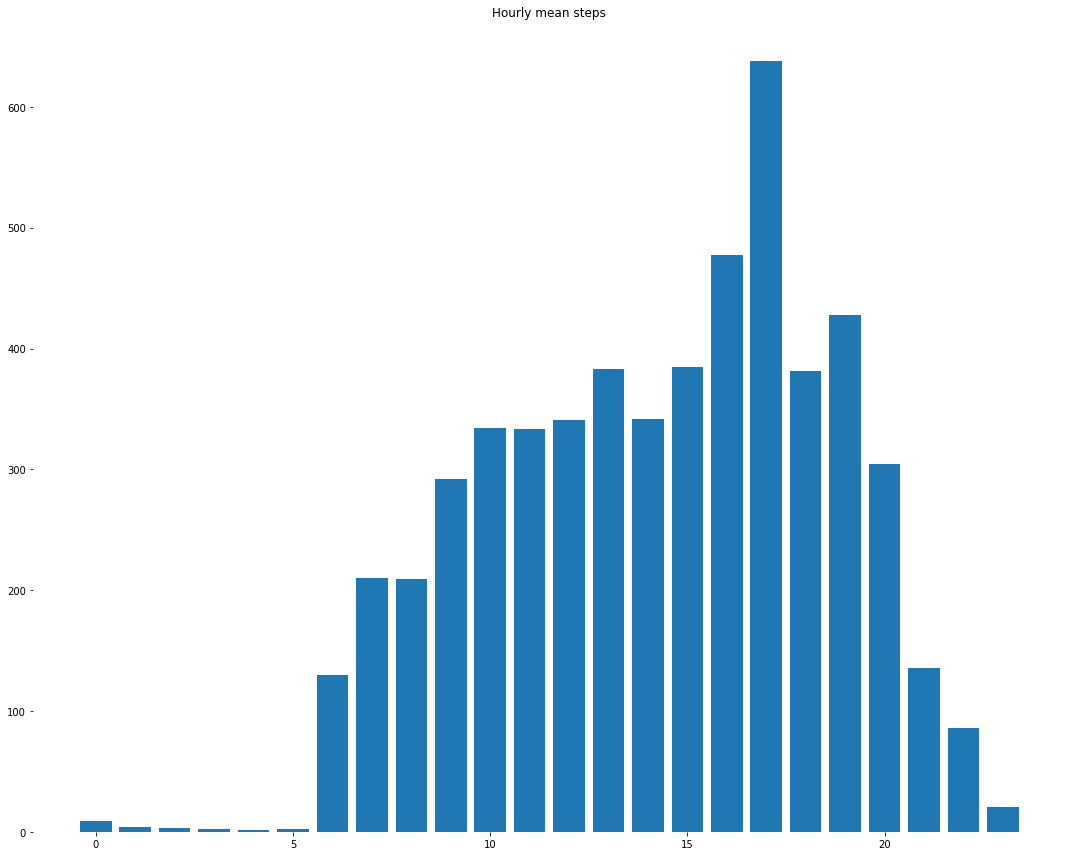

In [25]:
hourly_mean = df['value'].resample('H').sum()
hourly_mean = hourly_mean.groupby(hourly_mean.index.hour).mean()
fig, ax = plt.subplots(figsize=(15, 12))
ax.bar(hourly_mean.index, hourly_mean)
plt.title(f'Hourly mean steps')
plt.box(False)
plt.tight_layout()
plt.savefig(OUTPUT_CHARTS_DIR + 'hourly_mean_steps.png', dpi=300)

## Average 15-mins steps during the day <a name="15min"></a>

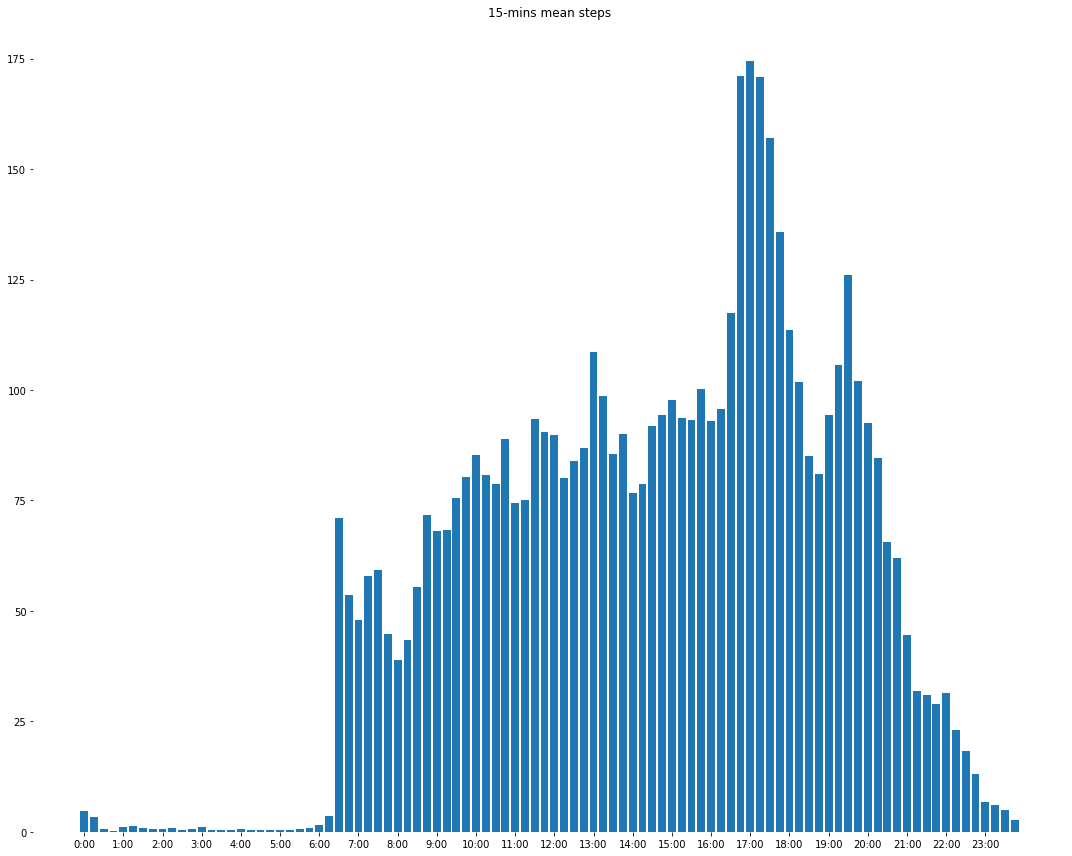

In [28]:
mins15_mean = df['value'].resample('15T').sum()
# now groupby hour+minute to get the daily average in the given 15-mins interval
mins15_mean = mins15_mean.groupby([mins15_mean.index.hour, mins15_mean.index.minute]).mean()
# revert the MultiIndex to a single DateTimeIndex so that we can use the HourLocator
mins15_mean.index = mins15_mean.index.map(lambda t: '{}:{:02}'.format(*t))
fig, ax = plt.subplots(figsize=(15, 12))
ax.bar(mins15_mean.index, mins15_mean)
plt.xticks(mins15_mean.index[::4])
plt.title(f'15-mins mean steps')
plt.box(False)
plt.tight_layout()
plt.savefig(OUTPUT_CHARTS_DIR + '15mins_mean_steps.png', dpi=300)

## Average steps per day of the week <a name="dow"></a>

	Average steps on Monday    4866
	Average steps on Tuesday   5151
	Average steps on Wednesday 5077
	Average steps on Thursday  5321
	Average steps on Friday    5655
	Average steps on Saturday  7030
	Average steps on Sunday    5063


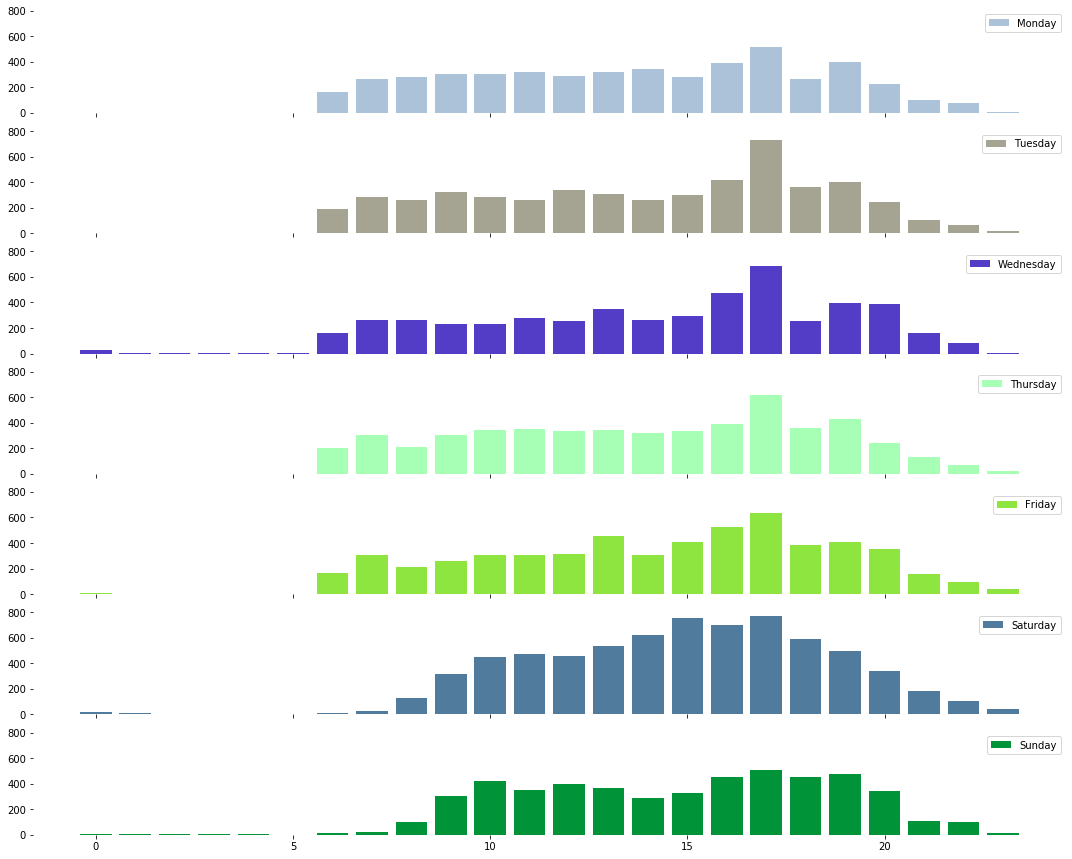

In [27]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday',]
weekday_hourly_mean = df['value'].resample('H').sum()
weekday_hourly_mean = weekday_hourly_mean.groupby([weekday_hourly_mean.index.dayofweek,
                                                   weekday_hourly_mean.index.hour]).mean()
fig, axs = plt.subplots(7, 1, sharey=True, sharex=True, figsize=(15, 12))
for day in range(7):
    print(f'\tAverage steps on {days[day]: <9} {weekday_hourly_mean[day].sum():.0f}')
    ax = axs[day]
    ax.bar(weekday_hourly_mean[day].index, weekday_hourly_mean[day],
           # definitely not efficient choice of colors!
           label=f'{days[day]}', color=list(mcd.XKCD_COLORS.values())[day*11])
    ax.legend()
    # remove the frames of this subplot
    for pos in ['top', 'bottom', 'right', 'left']:
        ax.spines[pos].set_visible(False)
plt.tight_layout()
plt.savefig(OUTPUT_CHARTS_DIR + 'weekday_hourly_steps.png', dpi=300)